In [2]:
!nvidia-smi

Tue Mar 19 21:04:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              N/A / ERR! |      4MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torch.nn as nn

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.get_num_threads()

4

## Hipotezy

Użyty zostal model do MNIST z poprzednich zajęć, ale hiperparametryzacja została wykonana dla MNIST oraz CIFAR10 i było to warte, bo można porównać dobór parametrów dla modelu, który i tak dobrze się prezentuje oraz tego, co sie prezentuje gorzej. 

In [6]:
# create if not existts directory for models
!mkdir -p ./lab2-models

model_dir = './lab2-models'

In [7]:
# download mnist 
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)

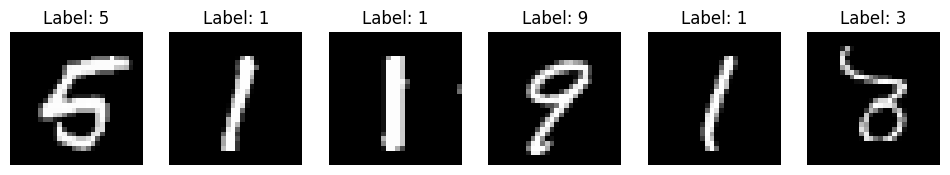

In [8]:
# sample data
import matplotlib.pyplot as plt

import numpy as np

loader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)

dataiter = iter(loader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = labels[i].item()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [9]:
# define model
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)        
        # return F.log_softmax(x, dim=1)
        return x

In [10]:
# train model

import torch.optim as optim
from sklearn.metrics import precision_score, f1_score
import time

def train(net, trainloader, criterion, optimizer):
    learning_start = time.time()
    
    net.train()

    accuracies = []
    losses = []
    f1s = []

    epochs = 10
    points_to_print = 200
    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))

    for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0
    
    learning_end = time.time()

    return losses, accuracies, f1s, learning_end - learning_start    

In [11]:
# test model

from torchmetrics import classification as metrics

def test(net, testloader, criterion, classnum):
    testing_start = time.time()
    
    accuracy = metrics.MulticlassAccuracy(num_classes=classnum, average='macro').cuda()
    f1 = metrics.MulticlassF1Score(num_classes=classnum, average='macro').cuda()
    total_loss = 0.0

    with torch.no_grad():
        net.eval()
        
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            accuracy.update(outputs, labels)
            f1.update(outputs, labels)
            
    
    testing_end = time.time()

    return total_loss / len(testloader), accuracy.compute().item(), f1.compute().item(), testing_end - testing_start

In [60]:
# plot training metrics

def plot(train_losses, train_accuracies, train_f1s):
    fig, ax1 = plt.subplots()
    
    metric_min = min(min(train_accuracies), min(train_f1s))

    color = 'tab:red'
    ax1.set_xlabel('batch')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(train_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([metric_min, 1])

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color = 'tab:gray'
    ax3.set_ylabel('f1', color=color)
    ax3.plot(train_f1s, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim([metric_min, 1])
    
    ax1.set_xlim([0, 200])

    fig.tight_layout()
    plt.title('Train accuracy, loss, precision and f1')
    plt.show()

In [13]:
# metric printing

def show_metrics(model):
    print(f'Name: {model.name}')
    print(f'Train time: {model.train_time:.2f} s')
    print(f'Test time: {model.test_time:.2f} s')
    print(f'Test loss: {model.test_loss:.3f}')
    print(f'Test accuracy: {model.test_accuracy*100:.3f}%')
    print(f'Test f1: {model.test_f1:.3f}')

In [14]:
# model wrapper

import pickle


class Model:
    def __init__(self, name, net, trainloader, criterion, optimizer):
        self.name = name
        self.net = net
        self.trainloader = trainloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.train_accuracies = []
        self.train_f1s = []
        self.train_time = 0

        self.test_loss = 0
        self.test_accuracy = 0
        self.test_f1 = 0
        self.test_time = 0

    def train_and_test(self):
        self.train()
        self.test()

    # train model
    def train(self):
        print(f'Training {self.name}...')
        self.train_losses, self.train_accuracies, self.train_f1s, self.train_time = train(
            self.net, self.trainloader, self.criterion, self.optimizer)

        self.save()

    # test model
    def test(self):
        print(f'Testing {self.name}...')
        self.test_loss, self.test_accuracy, self.test_f1, self.test_time = test(
            self.net, testloader, self.criterion, len(testset.classes))

        return self.test_accuracy, self.test_f1, self.test_time

    # plot model
    def plot(self):
        plot(self.train_losses, self.train_accuracies, self.train_f1s)

    def show_table(self):
        show_metrics(self)

    # save self to file
    def save(self):
        print(f'Saving {self.name}...')
        torch.save(self.net.state_dict(), f'{model_dir}/{self.name}.pth')

        with open(f'{model_dir}/{self.name}.pkl', 'wb') as f:
            pickle.dump(self, f)

    # load self from file
    @classmethod
    def load(cls, name):
        with open(f'{model_dir}/{name}.pkl', 'rb') as f:
            return pickle.load(f)

### Baseline model

In [15]:
# Base model

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

baseline_model = Model('baseline-model', net, trainloader, criterion, optimizer)
baseline_model.train_and_test()

baseline_model.show_table()

Training baseline-model...


[1,    24] loss: 2.155, accuracy: 0.337
[1,    48] loss: 1.290, accuracy: 0.587
[1,    72] loss: 0.696, accuracy: 0.777
[1,    96] loss: 0.480, accuracy: 0.842
[1,   120] loss: 0.343, accuracy: 0.902
[1,   144] loss: 0.268, accuracy: 0.918
[1,   168] loss: 0.218, accuracy: 0.939
[1,   192] loss: 0.214, accuracy: 0.934
[1,   216] loss: 0.172, accuracy: 0.945
[1,   240] loss: 0.178, accuracy: 0.950
[1,   264] loss: 0.161, accuracy: 0.950
[1,   288] loss: 0.140, accuracy: 0.960
[1,   312] loss: 0.148, accuracy: 0.959
[1,   336] loss: 0.116, accuracy: 0.966
[1,   360] loss: 0.141, accuracy: 0.956
[1,   384] loss: 0.127, accuracy: 0.959
[1,   408] loss: 0.112, accuracy: 0.959
[1,   432] loss: 0.096, accuracy: 0.970
[1,   456] loss: 0.117, accuracy: 0.966
[1,   480] loss: 0.123, accuracy: 0.964
[2,    24] loss: 0.108, accuracy: 0.969
[2,    48] loss: 0.099, accuracy: 0.969
[2,    72] loss: 0.116, accuracy: 0.964
[2,    96] loss: 0.106, accuracy: 0.968
[2,   120] loss: 0.098, accuracy: 0.973


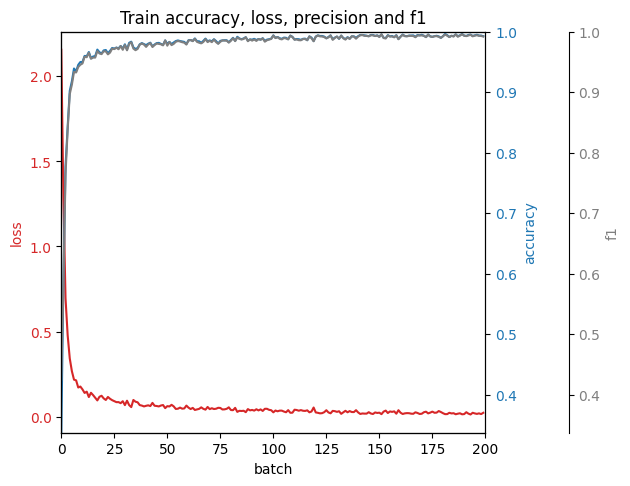

In [61]:
baseline_model.plot()

Są to wyniki dla modelu z poprzednich laboratoriów, do którego zostaną porównane inne z hipotez. Model się uczył 130 sekundy, a metryki są na poziomie 98%. Dane są zebrane w sposób, by na wykresach pokazywać ~200 punktów dla każdej metryki

### Hipoteza 1

In [17]:
# Hipothesis 1

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

batch_size_model = Model('hip-1-model', net, trainloader, criterion, optimizer)
batch_size_model.train_and_test()
batch_size_model.show_table()

Training hip-1-model...
[1,     3] loss: 2.300, accuracy: 0.096
[1,     6] loss: 2.278, accuracy: 0.120
[1,     9] loss: 2.245, accuracy: 0.311
[1,    12] loss: 2.192, accuracy: 0.460
[1,    15] loss: 2.104, accuracy: 0.608
[1,    18] loss: 1.979, accuracy: 0.648
[1,    21] loss: 1.799, accuracy: 0.654
[1,    24] loss: 1.588, accuracy: 0.671
[1,    27] loss: 1.379, accuracy: 0.699
[1,    30] loss: 1.122, accuracy: 0.734
[1,    33] loss: 0.950, accuracy: 0.753
[1,    36] loss: 0.817, accuracy: 0.771
[1,    39] loss: 0.710, accuracy: 0.789
[1,    42] loss: 0.638, accuracy: 0.804
[1,    45] loss: 0.527, accuracy: 0.837
[1,    48] loss: 0.516, accuracy: 0.844
[1,    51] loss: 0.435, accuracy: 0.865
[1,    54] loss: 0.440, accuracy: 0.872
[1,    57] loss: 0.431, accuracy: 0.869
[2,     3] loss: 0.410, accuracy: 0.876
[2,     6] loss: 0.377, accuracy: 0.889
[2,     9] loss: 0.355, accuracy: 0.885
[2,    12] loss: 0.346, accuracy: 0.893
[2,    15] loss: 0.317, accuracy: 0.906
[2,    18] loss:

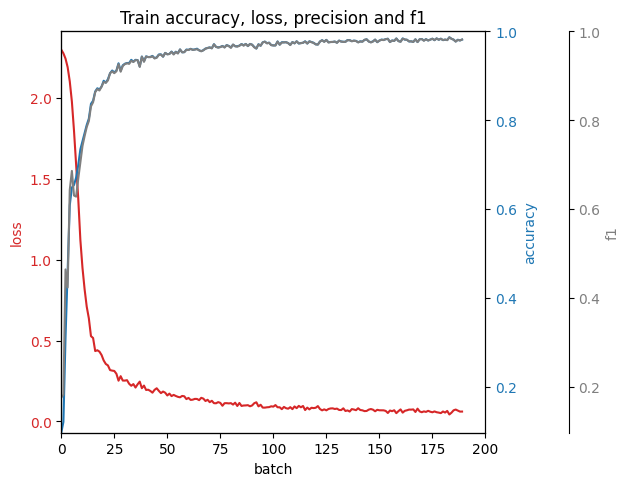

In [18]:
batch_size_model.plot()

Hipoteza 1: większy batch size sprawia, że model sie trenuje szybciej. 

Model został wytrenewany w ciągu 118 sekund, co rzeczywiście jest ~10 sekund szybsze. Też widzimy, że loss opada wolniej, co może być spowodowane tym, że rzadziej "robimy kroki", a rozmiar "kroku" pozostaje taki sam.

### Hipoteza 2

In [19]:
# Hopothesis 2

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

batch_size_learning_rate_model = Model('hip-2-model', net, trainloader, criterion, optimizer)
batch_size_learning_rate_model.train_and_test()

batch_size_learning_rate_model.show_table()

Training hip-2-model...
[1,     3] loss: 2.274, accuracy: 0.120
[1,     6] loss: 1.730, accuracy: 0.418
[1,     9] loss: 1.808, accuracy: 0.471
[1,    12] loss: 1.457, accuracy: 0.590
[1,    15] loss: 0.996, accuracy: 0.697
[1,    18] loss: 0.541, accuracy: 0.835
[1,    21] loss: 0.452, accuracy: 0.870
[1,    24] loss: 0.417, accuracy: 0.887
[1,    27] loss: 0.321, accuracy: 0.913
[1,    30] loss: 0.292, accuracy: 0.917
[1,    33] loss: 0.256, accuracy: 0.922
[1,    36] loss: 0.252, accuracy: 0.924
[1,    39] loss: 0.208, accuracy: 0.933
[1,    42] loss: 0.200, accuracy: 0.938
[1,    45] loss: 0.137, accuracy: 0.958
[1,    48] loss: 0.156, accuracy: 0.952
[1,    51] loss: 0.139, accuracy: 0.958
[1,    54] loss: 0.125, accuracy: 0.962
[1,    57] loss: 0.138, accuracy: 0.963
[2,     3] loss: 0.103, accuracy: 0.970
[2,     6] loss: 0.125, accuracy: 0.963
[2,     9] loss: 0.116, accuracy: 0.967
[2,    12] loss: 0.106, accuracy: 0.966
[2,    15] loss: 0.099, accuracy: 0.968
[2,    18] loss:

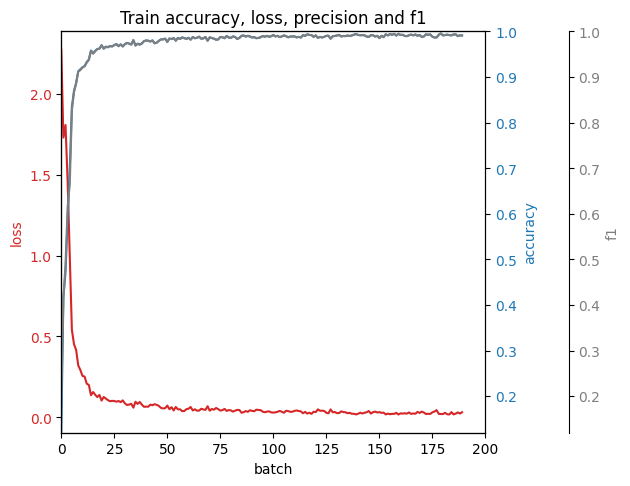

In [20]:
batch_size_learning_rate_model.plot()

Hipoteza 2: Da się uzyskąc podobne do referencyjnych wyników jeżeli przy zwiększonym batch size zwiększyć learning rate.

Rzeczywiście, wykres, oraz metryki pokazują bardzo zbliżone wyniki. Zwiekszyliśmy batch size ~10 raz, oraz learning rate 10 razy (ale zależność nie jest liniowa). W tym przypadku można to porównać do rzadszych kroków, ale większych.

### Hipoteza 3

In [37]:
# Hipothesis 3

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

sgd_model = Model('hip-3-model', net, trainloader, criterion, optimizer)
sgd_model.train_and_test()

sgd_model.show_table()

Training hip-3-model...
[1,    24] loss: 2.300, accuracy: 0.164
[1,    48] loss: 2.298, accuracy: 0.172
[1,    72] loss: 2.299, accuracy: 0.173
[1,    96] loss: 2.301, accuracy: 0.156
[1,   120] loss: 2.299, accuracy: 0.159
[1,   144] loss: 2.299, accuracy: 0.167
[1,   168] loss: 2.299, accuracy: 0.159
[1,   192] loss: 2.299, accuracy: 0.160
[1,   216] loss: 2.298, accuracy: 0.156
[1,   240] loss: 2.298, accuracy: 0.161
[1,   264] loss: 2.301, accuracy: 0.152
[1,   288] loss: 2.296, accuracy: 0.163
[1,   312] loss: 2.297, accuracy: 0.152
[1,   336] loss: 2.296, accuracy: 0.157
[1,   360] loss: 2.296, accuracy: 0.151
[1,   384] loss: 2.297, accuracy: 0.150
[1,   408] loss: 2.296, accuracy: 0.147
[1,   432] loss: 2.295, accuracy: 0.152
[1,   456] loss: 2.295, accuracy: 0.150
[1,   480] loss: 2.296, accuracy: 0.142
[2,    24] loss: 2.295, accuracy: 0.152
[2,    48] loss: 2.292, accuracy: 0.153
[2,    72] loss: 2.291, accuracy: 0.150
[2,    96] loss: 2.293, accuracy: 0.155
[2,   120] loss:

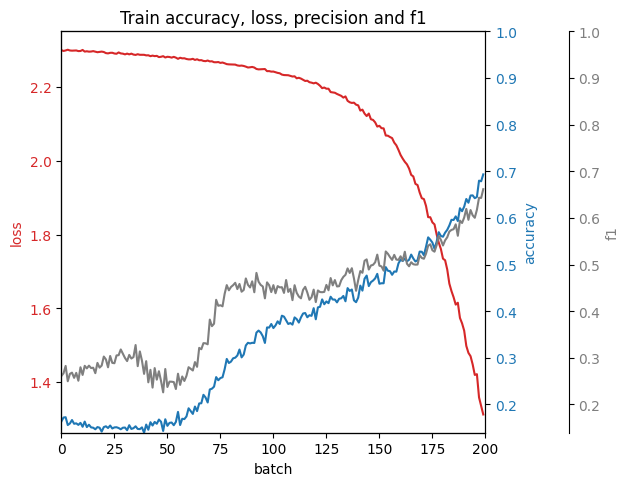

In [38]:
sgd_model.plot()

Hipoteza 3: ZGD potrzebuje dużej ilości "kroków" do dotarcia do najlepszego rozwiązania oraz wynik jest mocno zależny na wartościach wag początkowych.

I rzeczywiście, wykresy za każdym razem są bardzo różne a wyniki są na niższym poziomie. Natomiast bardzo dobrze to widać przy hiperparametryzji, że SGD może miec lepsze wyniki od Adam przy małym batch size (nawet 2 albo 4) i/lub dużej ilości epok.

### Hipoteza 4

In [62]:
# Hipothesis 4

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

sgd_momentum_model = Model('hip-4-model', net, trainloader, criterion, optimizer)
sgd_momentum_model.train_and_test()

sgd_momentum_model.show_table()

Training hip-4-model...


[1,    24] loss: 2.305, accuracy: 0.106
[1,    48] loss: 2.303, accuracy: 0.106
[1,    72] loss: 2.302, accuracy: 0.096
[1,    96] loss: 2.302, accuracy: 0.091
[1,   120] loss: 2.300, accuracy: 0.103
[1,   144] loss: 2.299, accuracy: 0.101
[1,   168] loss: 2.299, accuracy: 0.094
[1,   192] loss: 2.298, accuracy: 0.100
[1,   216] loss: 2.297, accuracy: 0.109
[1,   240] loss: 2.296, accuracy: 0.094
[1,   264] loss: 2.296, accuracy: 0.114
[1,   288] loss: 2.293, accuracy: 0.122
[1,   312] loss: 2.291, accuracy: 0.127
[1,   336] loss: 2.290, accuracy: 0.127
[1,   360] loss: 2.290, accuracy: 0.138
[1,   384] loss: 2.288, accuracy: 0.178
[1,   408] loss: 2.288, accuracy: 0.242
[1,   432] loss: 2.286, accuracy: 0.283
[1,   456] loss: 2.284, accuracy: 0.282
[1,   480] loss: 2.283, accuracy: 0.310
[2,    24] loss: 2.279, accuracy: 0.335
[2,    48] loss: 2.276, accuracy: 0.332
[2,    72] loss: 2.273, accuracy: 0.369
[2,    96] loss: 2.268, accuracy: 0.391
[2,   120] loss: 2.264, accuracy: 0.395


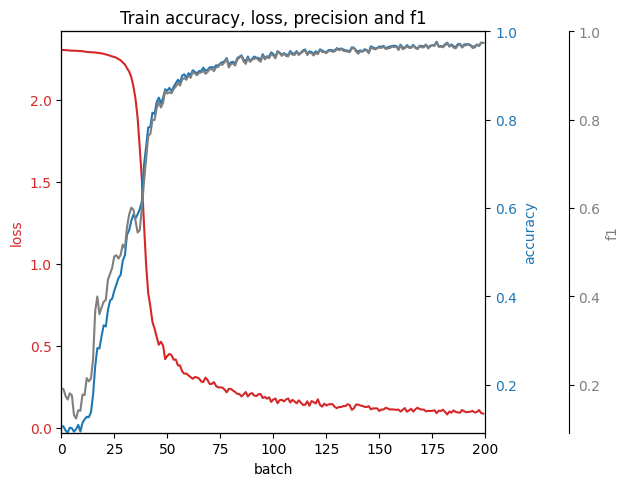

In [63]:
sgd_momentum_model.plot()

Hipoteza 4: SGD z momentum szybciej sie zbiega i nie daje utknąć.

SGD z momentum bierze pod uwagę poprzedni kierunek ruchu, co pozwala szybciej "dojść" do optimum.

### Hipoteza 5

In [25]:
# Hipothesis 5

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

sgd_momentum_decay_model = Model('hip-5-model', net, trainloader, criterion, optimizer)
sgd_momentum_decay_model.train_and_test()

sgd_momentum_decay_model.show_table()

Training hip-5-model...
[1,    24] loss: 2.302, accuracy: 0.113
[1,    48] loss: 2.304, accuracy: 0.107
[1,    72] loss: 2.303, accuracy: 0.102
[1,    96] loss: 2.302, accuracy: 0.091
[1,   120] loss: 2.299, accuracy: 0.096
[1,   144] loss: 2.299, accuracy: 0.089
[1,   168] loss: 2.298, accuracy: 0.089
[1,   192] loss: 2.297, accuracy: 0.085
[1,   216] loss: 2.293, accuracy: 0.100
[1,   240] loss: 2.291, accuracy: 0.099
[1,   264] loss: 2.289, accuracy: 0.110
[1,   288] loss: 2.288, accuracy: 0.110
[1,   312] loss: 2.288, accuracy: 0.089
[1,   336] loss: 2.284, accuracy: 0.097
[1,   360] loss: 2.281, accuracy: 0.108
[1,   384] loss: 2.279, accuracy: 0.094
[1,   408] loss: 2.275, accuracy: 0.107
[1,   432] loss: 2.272, accuracy: 0.109
[1,   456] loss: 2.267, accuracy: 0.131
[1,   480] loss: 2.264, accuracy: 0.169
[2,    24] loss: 2.258, accuracy: 0.224
[2,    48] loss: 2.251, accuracy: 0.285
[2,    72] loss: 2.244, accuracy: 0.314
[2,    96] loss: 2.233, accuracy: 0.380
[2,   120] loss:

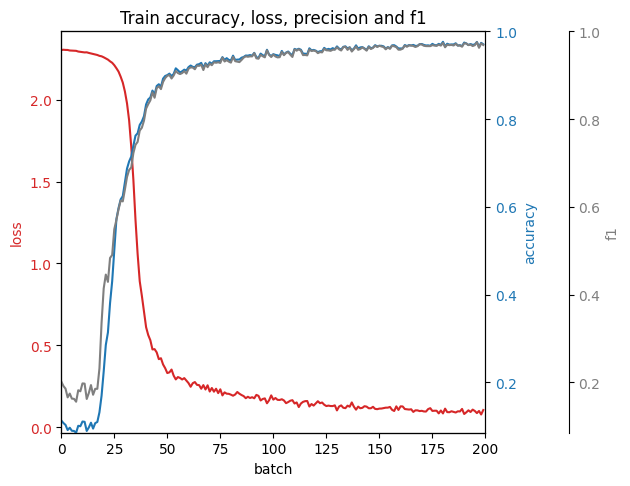

In [26]:
sgd_momentum_decay_model.plot()

Hipoteza 5: decay pozwala na zmiejszenie fluktuacji dookoła optmium.

Model uzyskał troche lepsze wyniki, niż model z hipotezy 5. Też wykres jest bardziej gładki. Dlatego i służy decay, by stopniowo zmniejszać learning rate, czyli robić cora mniejsze "kroki", by dotrzeć do optimum.

### Hipoteza 6

In [27]:
# Hipothesis 6

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nll_model = Model('hip-6-model', net, trainloader, criterion, optimizer)
nll_model.train_and_test()

nll_model.show_table()

Training hip-6-model...
[1,    24] loss: 2.114, accuracy: 0.358
[1,    48] loss: 1.088, accuracy: 0.711
[1,    72] loss: 0.560, accuracy: 0.824
[1,    96] loss: 0.443, accuracy: 0.864
[1,   120] loss: 0.348, accuracy: 0.892
[1,   144] loss: 0.304, accuracy: 0.906
[1,   168] loss: 0.284, accuracy: 0.916
[1,   192] loss: 0.221, accuracy: 0.935
[1,   216] loss: 0.220, accuracy: 0.938
[1,   240] loss: 0.196, accuracy: 0.937
[1,   264] loss: 0.189, accuracy: 0.942
[1,   288] loss: 0.150, accuracy: 0.955
[1,   312] loss: 0.172, accuracy: 0.949
[1,   336] loss: 0.126, accuracy: 0.962
[1,   360] loss: 0.130, accuracy: 0.959
[1,   384] loss: 0.121, accuracy: 0.964
[1,   408] loss: 0.138, accuracy: 0.958
[1,   432] loss: 0.119, accuracy: 0.965
[1,   456] loss: 0.121, accuracy: 0.965
[1,   480] loss: 0.099, accuracy: 0.969
[2,    24] loss: 0.092, accuracy: 0.970
[2,    48] loss: 0.099, accuracy: 0.969
[2,    72] loss: 0.110, accuracy: 0.968
[2,    96] loss: 0.101, accuracy: 0.969
[2,   120] loss:

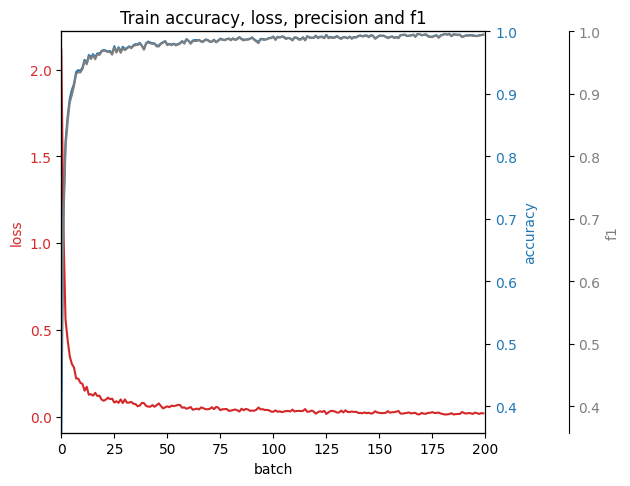

In [28]:
nll_model.plot()

Hipoteza 6: z log_softmax na koniec NllLoss moze dawac lepsze wyniki

Model 6 wykazał się najmniejszym lossem oraz drugim accuracy. Też przy hiperoptymalizacji top 2 to jest NllLoss.

### Hipoteza 7

In [29]:
# Hipothesis 7

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

rms_model = Model('hip-7-model', net, trainloader, criterion, optimizer)
rms_model.train_and_test()

rms_model.show_table()

Training hip-7-model...


[1,    24] loss: 1.360, accuracy: 0.532
[1,    48] loss: 0.457, accuracy: 0.861
[1,    72] loss: 0.295, accuracy: 0.905
[1,    96] loss: 0.249, accuracy: 0.918
[1,   120] loss: 0.201, accuracy: 0.934
[1,   144] loss: 0.178, accuracy: 0.947
[1,   168] loss: 0.170, accuracy: 0.944
[1,   192] loss: 0.140, accuracy: 0.960
[1,   216] loss: 0.142, accuracy: 0.954
[1,   240] loss: 0.133, accuracy: 0.961
[1,   264] loss: 0.118, accuracy: 0.966
[1,   288] loss: 0.118, accuracy: 0.967
[1,   312] loss: 0.108, accuracy: 0.965
[1,   336] loss: 0.113, accuracy: 0.964
[1,   360] loss: 0.102, accuracy: 0.967
[1,   384] loss: 0.085, accuracy: 0.972
[1,   408] loss: 0.109, accuracy: 0.962
[1,   432] loss: 0.119, accuracy: 0.964
[1,   456] loss: 0.083, accuracy: 0.974
[1,   480] loss: 0.086, accuracy: 0.975
[2,    24] loss: 0.086, accuracy: 0.972
[2,    48] loss: 0.089, accuracy: 0.972
[2,    72] loss: 0.085, accuracy: 0.973
[2,    96] loss: 0.085, accuracy: 0.973
[2,   120] loss: 0.091, accuracy: 0.970


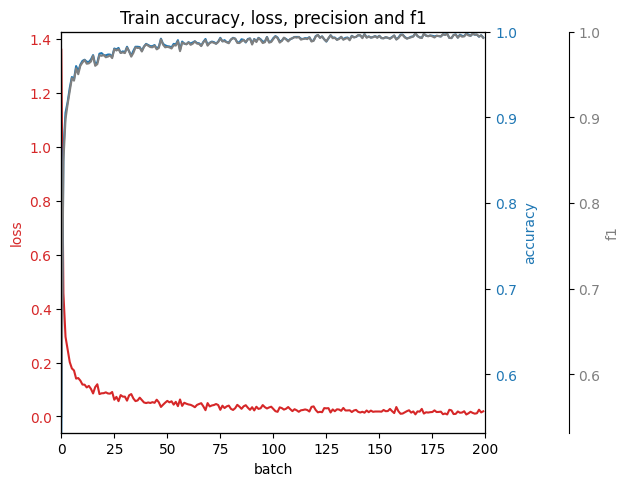

In [40]:
rms_model.plot()

W tym przypadku chciałem spróbować innego optimizera (RMSprop teoretycznie wymaga mniej pamieci). Ciekawym faktem jest to, że jest to sieć bardzo blizka najlepszej sieci z hiperoptymalizacji, gdzie zostało przetworzono 200 parameter setów.

### Wyniki

In [74]:
### add all 8 models values to pd dataframe

import pandas as pd

df = pd.DataFrame(columns=['model', 'train_losses', 'train_accuracies', 'train_f1s', 'train_time', 'test_time', 'test_loss', 'test_accuracy', 'test_f1'])

# clear df

df = df[0:0]

models = [baseline_model, batch_size_model, batch_size_learning_rate_model, sgd_model, sgd_momentum_model, sgd_momentum_decay_model, nll_model, rms_model]


for model in models:
    df = df.append({
        'model': model.name,
        'train_losses': model.train_losses,
        'train_accuracies': model.train_accuracies,
        'train_f1s': model.train_f1s,
        'train_time': model.train_time,
        'test_time': model.test_time,
        'test_loss': model.test_loss,
        'test_accuracy': model.test_accuracy,
        'test_f1': model.test_f1
    }, ignore_index=True)



/tmp/ipykernel_15070/376858778.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_15070/376858778.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_15070/376858778.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_15070/376858778.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_15070/376858778.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_15070/376858778.py:15: FutureWarnin

In [65]:
no_array_columns = ['model', 'train_time', 'test_time', 'test_loss', 'test_accuracy', 'test_f1']

In [77]:
# show head of only not array columns
    
df[no_array_columns].head(8)

,model,train_time,test_time,test_loss,test_accuracy,test_f1
0,baseline-model,129.672810,1.690679,0.037769,0.988375,0.988213
1,hip-1-model,118.102881,1.618845,0.053540,0.983735,0.983705
2,hip-2-model,125.502360,1.662610,0.050748,0.984188,0.984093
3,hip-3-model,135.259766,1.532732,1.285616,0.696456,0.681196
4,hip-4-model,132.829938,1.689801,0.089982,0.970358,0.970661
5,hip-5-model,144.364989,1.598285,0.085054,0.972417,0.972382
6,hip-6-model,141.356263,1.727488,0.034775,0.988363,0.988491
7,hip-7-model,131.321829,1.527507,0.040931,0.988249,0.988212


In [67]:
# sort by loss

df.sort_values(by='test_loss', ascending=True)[no_array_columns].head(8)

,model,train_time,test_time,test_loss,test_accuracy,test_f1
6,hip-6-model,141.356263,1.727488,0.034775,0.988363,0.988491
0,baseline-model,129.672810,1.690679,0.037769,0.988375,0.988213
7,hip-7-model,131.321829,1.527507,0.040931,0.988249,0.988212
2,hip-2-model,125.502360,1.662610,0.050748,0.984188,0.984093
1,hip-1-model,118.102881,1.618845,0.053540,0.983735,0.983705
5,hip-5-model,144.364989,1.598285,0.085054,0.972417,0.972382
4,hip-4-model,132.829938,1.689801,0.089982,0.970358,0.970661
3,hip-3-model,135.259766,1.532732,1.285616,0.696456,0.681196


In [68]:
# sort by accuracy

df.sort_values(by='test_accuracy', ascending=False)[no_array_columns].head(8)

,model,train_time,test_time,test_loss,test_accuracy,test_f1
0,baseline-model,129.672810,1.690679,0.037769,0.988375,0.988213
6,hip-6-model,141.356263,1.727488,0.034775,0.988363,0.988491
7,hip-7-model,131.321829,1.527507,0.040931,0.988249,0.988212
2,hip-2-model,125.502360,1.662610,0.050748,0.984188,0.984093
1,hip-1-model,118.102881,1.618845,0.053540,0.983735,0.983705
5,hip-5-model,144.364989,1.598285,0.085054,0.972417,0.972382
4,hip-4-model,132.829938,1.689801,0.089982,0.970358,0.970661
3,hip-3-model,135.259766,1.532732,1.285616,0.696456,0.681196


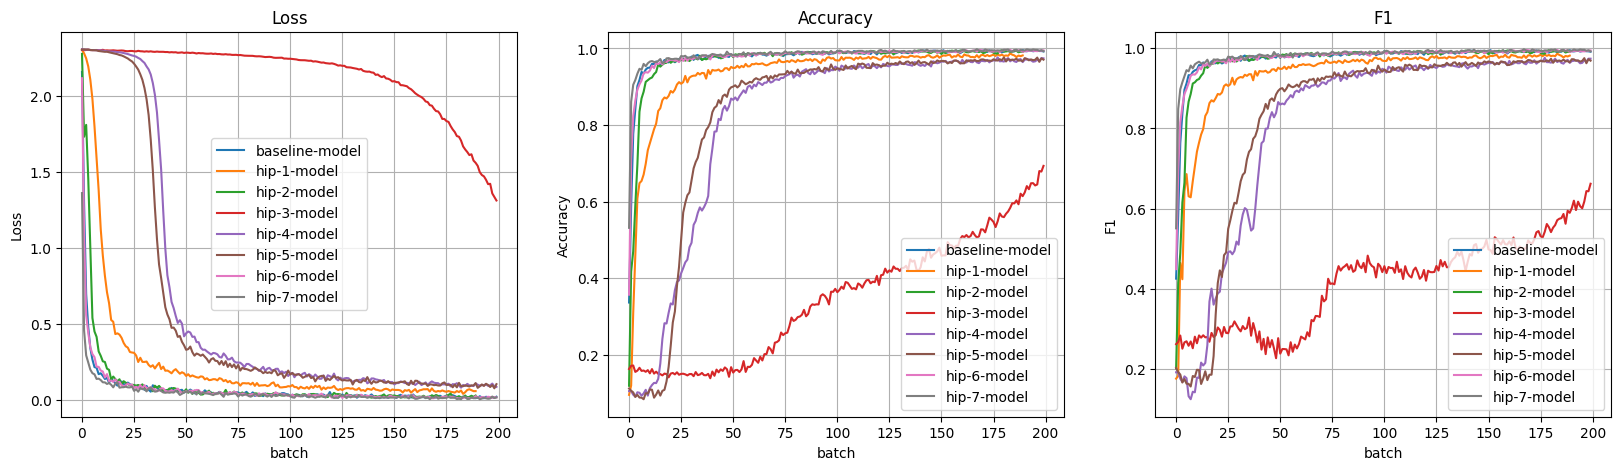

In [78]:
# plot every model loss on one plot, accuracies on one another and f1 on one another, everything in one row

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for model in models:
    ax[0].plot(model.train_losses, label=model.name)
    ax[1].plot(model.train_accuracies, label=model.name)
    ax[2].plot(model.train_f1s, label=model.name)

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('F1')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[2].set_ylabel('F1')

for a in ax:
    a.set_xlabel('batch')
    a.grid()
    a.legend()


plt.show()

Ostatecznie modelem, który najbardziej mi sie podoba jest model z hipotezy 6 z NllLoss.

## Hiperparametryzacja

### Mnist

W celu znalezienia najlepszej parametryzacji został użyty framework Ray, zostały zbadane 200 zestawów parametrow z poniższego parametr space na ponad 40 maszynach EC2 t3.large AWS (tylko CPU). Uczenie trwało 47 minut wraz z podnoszeniem się worker nodów (natomiast ustawienie środowiska 24 goziny). Szukany był wynik o najmniejszym loss. Scrypt jest w pliku o nazwie `lab02-mnist.py`, cały log wykonania jest w pliku `lab02-mnist.ray.log`. Ray też optymalizuje koszty, bo z jednej strony ma autoscaling, gdzie maszyny wirtualne są podnoszene tylko na czas liczenia i ich ilość dynamicznie się zmienia w zależnośći od obecnego obciążenia. Są też odrazu checkpointy, do których można zapisać np. stan sieci. W tym przypadku checkpointy są przechowywane na S3.

Parameter space

```py
config = {
    "optimizer": tune.choice(
        [
            {'name': 'adam'},
            {
                'name': 'sgd',
                'momentum': tune.choice([0, 0.9])
            },
            {'name': 'rmsprop'}
        ]
    ),
    "loss_function": tune.choice(['nnloss', 'crossentropy']),
    "batch_size": tune.choice([2, 4, 8, 16, 32, 64, 128, 512, 1024]),
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "smoke_test": smoke_test,
}
```

<style>
pre {
    width: 100%;
    overflow-x:scroll;
}
</style>

<pre>

Trial status: 200 TERMINATED
Current time: 2024-03-18 12:01:09. Total running time: 47min 42s
Logical resource usage: 1.0/10 CPUs, 0/0 GPUs
Current best trial: 37948_00137 with val_loss=0.03660061379798678 and params={'optimizer': {'name': 'rmsprop'}, 'loss_function': 'crossentropy', 'batch_size': 8, 'learning_rate': 0.0001609537487168266, 'smoke_test': False}


<------- TABELKA Z WYNIKAMI POMINIETA, BO JEST PODANA PONIZEJ ------->


Getting best result
Best trial config: {'optimizer': {'name': 'rmsprop'}, 'loss_function': 'crossentropy', 'batch_size': 8, 'learning_rate': 0.0001609537487168266, 'smoke_test': False}
Best trial final validation loss: 0.03660061379798678
Best trial final validation accuracy: 0.989
Best trial test set accuracy: 0.9891
Best trial test set f1: 0.9889863133430481
</pre>

In [70]:
table = """
Trial name                status       optimizer              loss_function       batch_size     learning_rate     iter     total time (s)     val_loss     val_accuracy      val_f1
train_cifar_37948_00000   TERMINATED   {'name': 'adam'}       crossentropy                 4       0.00593937         1           276.859     0.229467         0.93875     0.937833 
train_cifar_37948_00001   TERMINATED   {'name': 'rmsprop'}    crossentropy                64       0.000874519       10           290.728     0.0482978        0.98925     0.989182 
train_cifar_37948_00002   TERMINATED   {'name': 'rmsprop'}    nnloss                       8       0.000905241        2           153.239     0.0775621        0.97925     0.979253 
train_cifar_37948_00003   TERMINATED   ...', 'momentum': 0}   crossentropy               512       0.00447346         1            21.1712    2.29977          0.110917    0.0322861
train_cifar_37948_00004   TERMINATED   {'name': 'adam'}       nnloss                     512       0.0164789          4           112.027     0.0527093        0.985333    0.985178 
train_cifar_37948_00005   TERMINATED   {'name': 'adam'}       crossentropy                64       0.000138713        1            51.9258    0.323739         0.905917    0.904283 
train_cifar_37948_00006   TERMINATED   {'name': 'rmsprop'}    nnloss                       2       0.000611412        4           892.548     0.27008          0.95375     0.953884 
train_cifar_37948_00007   TERMINATED   ...', 'momentum': 0}   nnloss                     128       0.002734           1            33.0944    2.28326          0.202       0.102242 
train_cifar_37948_00008   TERMINATED   {'name': 'rmsprop'}    nnloss                     512       0.00141569         1            28.2063    0.141831         0.9565      0.956385 
train_cifar_37948_00009   TERMINATED   {'name': 'adam'}       nnloss                      64       0.00886303         2            91.9908    0.0829878        0.977083    0.976712 
train_cifar_37948_00010   TERMINATED   {'name': 'rmsprop'}    nnloss                      64       0.00313936         4           105.759     0.0651042        0.98225     0.982058 
train_cifar_37948_00011   TERMINATED   {'name': 'rmsprop'}    crossentropy                 4       0.0667941          1           240.806     2.31868          0.10875     0.0196167
train_cifar_37948_00012   TERMINATED   {'name': 'rmsprop'}    nnloss                    1024       0.000279644        1            29.5537    0.560863         0.838583    0.83004  
train_cifar_37948_00013   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.00022175         1            35.7569    0.219746         0.935833    0.935283 
train_cifar_37948_00014   TERMINATED   {'name': 'rmsprop'}    crossentropy               512       0.00788307         2            53.3789    0.139425         0.954       0.953403 
train_cifar_37948_00015   TERMINATED   {'name': 'adam'}       nnloss                     512       0.00115462         1            30.8584    0.244181         0.925083    0.924275 
train_cifar_37948_00016   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.00112758         1            21.6299    0.441763         0.864       0.862829 
train_cifar_37948_00017   TERMINATED   {'name': 'adam'}       nnloss                       2       0.00670595         1           348.374     0.336663         0.921333    0.921491 
train_cifar_37948_00018   TERMINATED   {'name': 'rmsprop'}    nnloss                       4       0.0440304          1           293.883     2.31702          0.10075     0.0183057
train_cifar_37948_00019   TERMINATED   ... 'momentum': 0.9}   nnloss                     128       0.0119395          2            48.8199    0.0901108        0.971667    0.971426 
train_cifar_37948_00020   TERMINATED   ...', 'momentum': 0}   nnloss                      16       0.000181308        1            58.1459    2.29815          0.104       0.0250007
train_cifar_37948_00021   TERMINATED   {'name': 'adam'}       crossentropy                 8       0.000993408        4           393.651     0.0600888        0.9845      0.984405 
train_cifar_37948_00022   TERMINATED   ...', 'momentum': 0}   crossentropy                 2       0.00175296        10          2378.65      0.0448128        0.986583    0.98653  
train_cifar_37948_00023   TERMINATED   ...', 'momentum': 0}   nnloss                       4       0.0583256          2           345.476     0.127408         0.963583    0.963222 
train_cifar_37948_00024   TERMINATED   {'name': 'rmsprop'}    crossentropy                16       0.0977764          1            50.3096    2.32865          0.109333    0.0197115
train_cifar_37948_00025   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.00721787         2            57.2338    0.0914437        0.970917    0.970834 
train_cifar_37948_00026   TERMINATED   {'name': 'adam'}       nnloss                       2       0.00234749         2           756.284     0.154738         0.961583    0.961416 
train_cifar_37948_00027   TERMINATED   {'name': 'adam'}       crossentropy               128       0.00104635         2            64.5038    0.080177         0.976583    0.976358 
train_cifar_37948_00028   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.0011824         10           288.284     0.0611093        0.985417    0.985224 
train_cifar_37948_00029   TERMINATED   {'name': 'rmsprop'}    crossentropy               512       0.000102172        1            21.7111    0.889138         0.795       0.782488 
train_cifar_37948_00030   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.0068041          2           283.975     0.195175         0.947       0.946769 
train_cifar_37948_00031   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.00296129        10           244.123     0.0550342        0.98725     0.987157 
train_cifar_37948_00032   TERMINATED   ... 'momentum': 0.9}   crossentropy                64       0.0309615          4           165.793     0.0623157        0.982417    0.982263 
train_cifar_37948_00033   TERMINATED   {'name': 'rmsprop'}    nnloss                       4       0.010761           1           127.009     2.30745          0.10325     0.0187174
train_cifar_37948_00034   TERMINATED   ... 'momentum': 0.9}   nnloss                    1024       0.014821           1            23.0042    2.22646          0.288667    0.262765 
train_cifar_37948_00035   TERMINATED   {'name': 'adam'}       nnloss                      64       0.00285952         4           100.538     0.0679676        0.981333    0.981268 
train_cifar_37948_00036   TERMINATED   {'name': 'adam'}       crossentropy               512       0.000122543        1            25.5219    1.89626          0.565583    0.483313 
train_cifar_37948_00037   TERMINATED   {'name': 'adam'}       nnloss                       8       0.035816           1           109.255     2.32184          0.100333    0.0182369
train_cifar_37948_00038   TERMINATED   ...', 'momentum': 0}   crossentropy               512       0.000312154        1            20.6276    2.3053           0.0821667   0.026598 
train_cifar_37948_00039   TERMINATED   {'name': 'rmsprop'}    crossentropy                16       0.00321977         2           144.198     0.0902393        0.975083    0.974808 
train_cifar_37948_00040   TERMINATED   {'name': 'adam'}       crossentropy                16       0.0265003          1            62.1329    1.4014           0.72575     0.723843 
train_cifar_37948_00041   TERMINATED   ... 'momentum': 0.9}   crossentropy                64       0.00112841         1            30.8929    0.688799         0.813083    0.809618 
train_cifar_37948_00042   TERMINATED   {'name': 'adam'}       nnloss                      64       0.00503755         4           114.575     0.0792347        0.980417    0.980316 
train_cifar_37948_00043   TERMINATED   ...', 'momentum': 0}   crossentropy                16       0.00438243         1            63.2186    0.308185         0.908917    0.909669 
train_cifar_37948_00044   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.0805738          1            21.5906    2.30317          0.11425     0.0205071
train_cifar_37948_00045   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.000275469       10           709.836     0.0452296        0.988333    0.988178 
train_cifar_37948_00046   TERMINATED   {'name': 'adam'}       nnloss                     128       0.000295409        1            37.3115    0.220816         0.934917    0.934369 
train_cifar_37948_00047   TERMINATED   {'name': 'rmsprop'}    nnloss                    1024       0.000126265        1            35.2807    1.21681          0.736083    0.707721 
train_cifar_37948_00048   TERMINATED   {'name': 'adam'}       crossentropy                64       0.00463768         2            53.718     0.0706258        0.978667    0.978609 
train_cifar_37948_00049   TERMINATED   {'name': 'adam'}       nnloss                       8       0.0089901          1           121.381     0.291556         0.922917    0.922074 
train_cifar_37948_00050   TERMINATED   {'name': 'adam'}       nnloss                       2       0.000902649        4          1143.61      0.0681189        0.982167    0.98178  
train_cifar_37948_00051   TERMINATED   ...', 'momentum': 0}   nnloss                      32       0.0571769          4           135.099     0.0605029        0.98275     0.98254  
train_cifar_37948_00052   TERMINATED   {'name': 'adam'}       crossentropy               128       0.00052096         2            44.943     0.110837         0.966333    0.966183 
train_cifar_37948_00053   TERMINATED   ...', 'momentum': 0}   crossentropy                 2       0.00115103         2           563.706     0.095287         0.969667    0.96974  
train_cifar_37948_00054   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.000190139        1            30.7469    2.10336          0.419583    0.325657 
train_cifar_37948_00055   TERMINATED   ... 'momentum': 0.9}   crossentropy                32       0.000861183        1            52.0791    0.277378         0.917167    0.916144 
train_cifar_37948_00056   TERMINATED   ...', 'momentum': 0}   nnloss                     128       0.0473307          1            25.0489    0.23385          0.9265      0.925695 
train_cifar_37948_00057   TERMINATED   {'name': 'rmsprop'}    nnloss                      16       0.00586615         2           173.66      0.144781         0.967083    0.966943 
train_cifar_37948_00058   TERMINATED   {'name': 'rmsprop'}    crossentropy                 4       0.000153537        2           457.606     0.0929332        0.971       0.970824 
train_cifar_37948_00059   TERMINATED   {'name': 'adam'}       crossentropy                16       0.00240194         2           118.132     0.0844433        0.974583    0.974513 
train_cifar_37948_00060   TERMINATED   {'name': 'rmsprop'}    crossentropy                16       0.00208364         4           281.974     0.0828295        0.978667    0.978467 
train_cifar_37948_00061   TERMINATED   ... 'momentum': 0.9}   crossentropy               512       0.00259786         1            27.436     2.29351          0.199583    0.0893482
train_cifar_37948_00062   TERMINATED   ...', 'momentum': 0}   crossentropy                64       0.00536163         1            31.4589    2.19111          0.43875     0.366487 
train_cifar_37948_00063   TERMINATED   {'name': 'rmsprop'}    crossentropy               512       0.00669552         1            23.1504    0.213622         0.933333    0.933421 
train_cifar_37948_00064   TERMINATED   {'name': 'rmsprop'}    nnloss                      64       0.0349778          1            29.7473    0.562605         0.839417    0.836802 
train_cifar_37948_00065   TERMINATED   {'name': 'rmsprop'}    crossentropy                16       0.00473495         2           154.37      0.116888         0.9655      0.965411 
train_cifar_37948_00066   TERMINATED   ...', 'momentum': 0}   nnloss                     512       0.00301886         1            21.2311    2.30485          0.101417    0.0252148
train_cifar_37948_00067   TERMINATED   {'name': 'rmsprop'}    nnloss                       2       0.0127785          1           316.912     2.30796          0.104583    0.0189363
train_cifar_37948_00068   TERMINATED   ...', 'momentum': 0}   nnloss                      64       0.00531235         1            26.631     2.24716          0.43125     0.313437 
train_cifar_37948_00069   TERMINATED   ... 'momentum': 0.9}   crossentropy               128       0.00406062         1            22.3291    0.249851         0.927333    0.926511 
train_cifar_37948_00070   TERMINATED   {'name': 'adam'}       crossentropy               512       0.0608542          1            20.5147    2.30301          0.114583    0.0205607
train_cifar_37948_00071   TERMINATED   {'name': 'rmsprop'}    crossentropy               512       0.00333096         2            50.2161    0.0890113        0.973583    0.973387 
train_cifar_37948_00072   TERMINATED   ...', 'momentum': 0}   crossentropy               512       0.03426            1            21.8741    2.2515           0.327417    0.210344 
train_cifar_37948_00073   TERMINATED   {'name': 'adam'}       crossentropy               512       0.000156594        1            20.5771    1.48247          0.747917    0.70127  
train_cifar_37948_00074   TERMINATED   {'name': 'adam'}       crossentropy               128       0.0668838          1            23.9004    2.3055           0.113833    0.0204399
train_cifar_37948_00075   TERMINATED   ... 'momentum': 0.9}   nnloss                     128       0.098481           8           209.178     0.0726237        0.984833    0.984685 
train_cifar_37948_00076   TERMINATED   {'name': 'rmsprop'}    nnloss                      64       0.000719625        2            56.93      0.0841872        0.974583    0.974472 
train_cifar_37948_00077   TERMINATED   ...', 'momentum': 0}   crossentropy                32       0.000505733        1            33.3069    2.29601          0.100917    0.0183332
train_cifar_37948_00078   TERMINATED   {'name': 'rmsprop'}    nnloss                     512       0.000258225        1            19.1444    0.351389         0.90175     0.901417 
train_cifar_37948_00079   TERMINATED   {'name': 'adam'}       nnloss                       4       0.000587661        4           477.581     0.0611192        0.985667    0.985574 
train_cifar_37948_00080   TERMINATED   ... 'momentum': 0.9}   crossentropy              1024       0.00185281         1            24.3505    2.29834          0.120083    0.0435525
train_cifar_37948_00081   TERMINATED   {'name': 'adam'}       crossentropy                 4       0.0688964          1           170.697     2.31696          0.106083    0.0191818
train_cifar_37948_00082   TERMINATED   ... 'momentum': 0.9}   crossentropy              1024       0.0393675          1            21.3606    2.30355          0.191083    0.0957337
train_cifar_37948_00083   TERMINATED   {'name': 'rmsprop'}    crossentropy              1024       0.0326042          1            24.058     2.3055           0.0998333   0.0181543
train_cifar_37948_00084   TERMINATED   {'name': 'adam'}       nnloss                      32       0.0038274          4           214.333     0.0657978        0.981667    0.981458 
train_cifar_37948_00085   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.00274217         2            91.1138    0.0853166        0.978       0.977911 
train_cifar_37948_00086   TERMINATED   {'name': 'rmsprop'}    nnloss                      32       0.0793563          1            41.1999    2.00704          0.2675      0.181712 
train_cifar_37948_00087   TERMINATED   {'name': 'adam'}       nnloss                       8       0.00777689         2           176         0.191437         0.954583    0.954075 
train_cifar_37948_00088   TERMINATED   {'name': 'adam'}       nnloss                      16       0.000298364        2           110.573     0.0820621        0.975083    0.974884 
train_cifar_37948_00089   TERMINATED   {'name': 'adam'}       crossentropy               128       0.000822042        2            45.6058    0.0834477        0.97475     0.974653 
train_cifar_37948_00090   TERMINATED   {'name': 'adam'}       crossentropy                 4       0.000344581        8          1144.61      0.0628465        0.985833    0.985751 
train_cifar_37948_00091   TERMINATED   ... 'momentum': 0.9}   crossentropy                 2       0.00226097         4           854.424     0.096658         0.977917    0.977851 
train_cifar_37948_00092   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.000702891        2            54.2943    0.0771417        0.9765      0.976282 
train_cifar_37948_00093   TERMINATED   {'name': 'rmsprop'}    crossentropy               512       0.000160938        1            20.4323    0.573392         0.860917    0.858584 
train_cifar_37948_00094   TERMINATED   {'name': 'rmsprop'}    crossentropy              1024       0.0113516          1            22.4473    2.30218          0.111       0.019982 
train_cifar_37948_00095   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.0962698          1            46.4136    2.31079          0.08825     0.0162187
train_cifar_37948_00096   TERMINATED   ...', 'momentum': 0}   nnloss                     512       0.0019637          1            30.1737    2.30035          0.12925     0.0459955
train_cifar_37948_00097   TERMINATED   ...', 'momentum': 0}   nnloss                      32       0.000323381        1            34.1294    2.29794          0.121333    0.0450501
train_cifar_37948_00098   TERMINATED   {'name': 'rmsprop'}    crossentropy                64       0.000565003       10           294.143     0.0402954        0.988333    0.98818  
train_cifar_37948_00099   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.00558703         2            43.4572    0.0898409        0.971333    0.971196 
train_cifar_37948_00100   TERMINATED   {'name': 'rmsprop'}    nnloss                     512       0.000129757        1            29.1101    0.744464         0.8275      0.822589 
train_cifar_37948_00101   TERMINATED   ... 'momentum': 0.9}   nnloss                      64       0.00069831         1            39.9852    2.22316          0.2255      0.173641 
train_cifar_37948_00102   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.00491437         2            44.4927    0.106367         0.966583    0.966493 
train_cifar_37948_00103   TERMINATED   {'name': 'adam'}       crossentropy                 8       0.000113207        2           191.826     0.112051         0.965583    0.965505 
train_cifar_37948_00104   TERMINATED   {'name': 'rmsprop'}    nnloss                      32       0.000344729        2            80.0016    0.0948049        0.970417    0.970378 
train_cifar_37948_00105   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.00148925         4           357.683     0.0680287        0.983083    0.982908 
train_cifar_37948_00106   TERMINATED   {'name': 'adam'}       nnloss                       8       0.0953535          1           165.546     2.32567          0.110667    0.019928 
train_cifar_37948_00107   TERMINATED   {'name': 'adam'}       crossentropy                64       0.0631981          1            29.318     2.30446          0.100333    0.0182369
train_cifar_37948_00108   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.081763           1            21.7107    2.31064          0.107833    0.0194674
train_cifar_37948_00109   TERMINATED   {'name': 'adam'}       crossentropy               128       0.0054396          2            50.7689    0.0952887        0.973083    0.973022 
train_cifar_37948_00110   TERMINATED   {'name': 'adam'}       nnloss                    1024       0.00638833        10           272.516     0.0369422        0.989833    0.989778 
train_cifar_37948_00111   TERMINATED   {'name': 'adam'}       nnloss                      16       0.00767137         2           118.153     0.126767         0.966583    0.966719 
train_cifar_37948_00112   TERMINATED   {'name': 'adam'}       nnloss                       8       0.00289042         2           169.547     0.101055         0.971917    0.971776 
train_cifar_37948_00113   TERMINATED   {'name': 'rmsprop'}    nnloss                       8       0.000302826        8           591.372     0.047147         0.986583    0.986424 
train_cifar_37948_00114   TERMINATED   {'name': 'adam'}       crossentropy                 2       0.00705217         1           417.265     0.372809         0.909167    0.909141 
train_cifar_37948_00115   TERMINATED   ...', 'momentum': 0}   nnloss                     512       0.000801761        1            22.49      2.30063          0.132833    0.0443271
train_cifar_37948_00116   TERMINATED   ... 'momentum': 0.9}   crossentropy                 4       0.00121356        10           906.649     0.0477699        0.989333    0.98926  
train_cifar_37948_00117   TERMINATED   ...', 'momentum': 0}   crossentropy                 2       0.0790577          1           259.242     2.31361          0.112167    0.0203285
train_cifar_37948_00118   TERMINATED   ...', 'momentum': 0}   crossentropy                 2       0.0100762          8          2210.5       0.0741571        0.980583    0.980728 
train_cifar_37948_00119   TERMINATED   {'name': 'adam'}       nnloss                      64       0.0188582          2            66.0918    0.211101         0.952917    0.952653 
train_cifar_37948_00120   TERMINATED   ... 'momentum': 0.9}   nnloss                      64       0.00120857         1            28.3525    0.561999         0.845417    0.843479 
train_cifar_37948_00121   TERMINATED   {'name': 'adam'}       nnloss                       4       0.0999068          1           178.763     2.33903          0.09625     0.0175599
train_cifar_37948_00122   TERMINATED   ...', 'momentum': 0}   nnloss                      16       0.0318215         10           476.099     0.0629713        0.983333    0.98324  
train_cifar_37948_00123   TERMINATED   {'name': 'adam'}       nnloss                       4       0.000335817       10          1293.44      0.0418528        0.989333    0.989224 
train_cifar_37948_00124   TERMINATED   {'name': 'adam'}       crossentropy                 2       0.00151149         2           487.786     0.10287          0.972417    0.972086 
train_cifar_37948_00125   TERMINATED   ...', 'momentum': 0}   crossentropy                 4       0.00471373        10          1624.36      0.0412089        0.98775     0.987534 
train_cifar_37948_00126   TERMINATED   ...', 'momentum': 0}   crossentropy                 2       0.00406841         2           500.454     0.0851037        0.974667    0.974765 
train_cifar_37948_00127   TERMINATED   {'name': 'rmsprop'}    crossentropy                 2       0.00855858         1           303.298     1.0308           0.806333    0.820024 
train_cifar_37948_00128   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.0085329          4            96.0424    0.0603906        0.981       0.980714 
train_cifar_37948_00129   TERMINATED   {'name': 'adam'}       nnloss                     512       0.0181537          4           100.787     0.0677233        0.98225     0.981986 
train_cifar_37948_00130   TERMINATED   {'name': 'adam'}       nnloss                    1024       0.0168606          2            49.9243    0.0832389        0.974       0.973823 
train_cifar_37948_00131   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.0640489          1            57.5374    2.30829          0.0961667   0.017546 
train_cifar_37948_00132   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.0437542          1            44.0845    1.53684          0.617667    0.623809 
train_cifar_37948_00133   TERMINATED   {'name': 'adam'}       nnloss                       4       0.000439255        8          1033.56      0.0555776        0.98575     0.985676 
train_cifar_37948_00134   TERMINATED   {'name': 'adam'}       nnloss                       8       0.000190087       10          1006.93      0.0539611        0.984583    0.984444 
train_cifar_37948_00135   TERMINATED   {'name': 'rmsprop'}    crossentropy                64       0.000375194        2            63.665     0.103738         0.968       0.967786 
train_cifar_37948_00136   TERMINATED   {'name': 'adam'}       nnloss                     128       0.0860949          1            26.8045    2.3069           0.1045      0.0189226
train_cifar_37948_00137   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.000160954       10           776.269     0.0366006        0.989       0.988844 
train_cifar_37948_00138   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.0049564          4           138.156     0.0623013        0.981417    0.981128 
train_cifar_37948_00139   TERMINATED   {'name': 'rmsprop'}    crossentropy                 2       0.0294402          1           356.389     2.31565          0.0975833   0.0177815
train_cifar_37948_00140   TERMINATED   ... 'momentum': 0.9}   nnloss                       2       0.00130436        10          1874.59      0.0480615        0.987333    0.987276 
train_cifar_37948_00141   TERMINATED   ...', 'momentum': 0}   crossentropy                 4       0.00228984         2           345.916     0.112811         0.96675     0.966669 
train_cifar_37948_00142   TERMINATED   ...', 'momentum': 0}   crossentropy                64       0.000741164        1            30.7466    2.30175          0.0985      0.0179403
train_cifar_37948_00143   TERMINATED   ... 'momentum': 0.9}   crossentropy               128       0.000305525        1            26.2989    2.29646          0.110833    0.0344597
train_cifar_37948_00144   TERMINATED   ... 'momentum': 0.9}   crossentropy                16       0.000501889        1            89.763     0.334682         0.89425     0.893403 
train_cifar_37948_00145   TERMINATED   {'name': 'adam'}       crossentropy               512       0.000264522        1            23.3515    0.830305         0.791083    0.780364 
train_cifar_37948_00146   TERMINATED   {'name': 'adam'}       nnloss                       2       0.0351381          1           373.167     2.32353          0.101083    0.0183607
train_cifar_37948_00147   TERMINATED   {'name': 'adam'}       nnloss                      32       0.0459113          1            46.7497    2.00945          0.218333    0.140437 
train_cifar_37948_00148   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.0168603          1            59.6555    0.301089         0.92625     0.925521 
train_cifar_37948_00149   TERMINATED   {'name': 'rmsprop'}    crossentropy                 2       0.000218268        8          1473.45      0.0544593        0.98425     0.984265 
train_cifar_37948_00150   TERMINATED   ... 'momentum': 0.9}   crossentropy                 4       0.00826795         1           127.976     0.274924         0.928       0.9277   
train_cifar_37948_00151   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.0267885          1            75.4158    2.30569          0.0975      0.0177677
train_cifar_37948_00152   TERMINATED   {'name': 'rmsprop'}    crossentropy                 2       0.00996628         1           283.143     0.938339         0.8775      0.876108 
train_cifar_37948_00153   TERMINATED   ... 'momentum': 0.9}   crossentropy                64       0.00934288         8           197.752     0.0507427        0.9845      0.984429 
train_cifar_37948_00154   TERMINATED   ...', 'momentum': 0}   crossentropy               128       0.0001492          1            24.14      2.30221          0.1175      0.0248764
train_cifar_37948_00155   TERMINATED   ...', 'momentum': 0}   crossentropy               128       0.00188754         1            25.5653    2.29114          0.272583    0.133589 
train_cifar_37948_00156   TERMINATED   ...', 'momentum': 0}   nnloss                       4       0.000202324        1           165.151     2.28959          0.116417    0.0304427
train_cifar_37948_00157   TERMINATED   ...', 'momentum': 0}   crossentropy                 2       0.0217131          4          1166.96      0.0882173        0.978583    0.978569 
train_cifar_37948_00158   TERMINATED   {'name': 'adam'}       crossentropy                 8       0.00629097         1            81.7494    0.327814         0.914417    0.911983 
train_cifar_37948_00159   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.000370931        8           526.644     0.0515338        0.987417    0.987336 
train_cifar_37948_00160   TERMINATED   {'name': 'adam'}       nnloss                     512       0.017462           2            47.7485    0.084903         0.973333    0.973501 
train_cifar_37948_00161   TERMINATED   ...', 'momentum': 0}   nnloss                      64       0.000183469        1            45.0427    2.30151          0.126917    0.0487197
train_cifar_37948_00162   TERMINATED   ... 'momentum': 0.9}   crossentropy               512       0.00132953         1            23.1583    2.29852          0.110833    0.0350161
train_cifar_37948_00163   TERMINATED   ...', 'momentum': 0}   nnloss                    1024       0.0069431          1            21.9841    2.30163          0.110167    0.0198469
train_cifar_37948_00164   TERMINATED   {'name': 'rmsprop'}    nnloss                     512       0.020893           1            21.8497    2.30341          0.108917    0.0196438
train_cifar_37948_00165   TERMINATED   {'name': 'adam'}       crossentropy              1024       0.0903595          1            24.0708    2.30242          0.113583    0.0204011
train_cifar_37948_00166   TERMINATED   {'name': 'rmsprop'}    nnloss                       8       0.000741879        4           400.719     0.0757471        0.978333    0.978589 
train_cifar_37948_00167   TERMINATED   ... 'momentum': 0.9}   crossentropy                 2       0.000630844       10          2123.28      0.0492354        0.989       0.988975 
train_cifar_37948_00168   TERMINATED   {'name': 'rmsprop'}    nnloss                       4       0.0540028          1           185.744     2.32056          0.0983333   0.0179059
train_cifar_37948_00169   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.000118309        2            77.5085    0.158283         0.953083    0.952901 
train_cifar_37948_00170   TERMINATED   {'name': 'rmsprop'}    crossentropy                64       0.00161019         2            50.4661    0.0865845        0.974       0.973738 
train_cifar_37948_00171   TERMINATED   ...', 'momentum': 0}   nnloss                    1024       0.0362198          1            25.2515    2.29163          0.17725     0.0602969
train_cifar_37948_00172   TERMINATED   {'name': 'adam'}       crossentropy               512       0.00217968         2            39.6409    0.107824         0.965417    0.965173 
train_cifar_37948_00173   TERMINATED   ...', 'momentum': 0}   crossentropy               512       0.000420362        1            25.632     2.30309          0.0961667   0.017546 
train_cifar_37948_00174   TERMINATED   {'name': 'rmsprop'}    nnloss                      32       0.0023306          4           148.528     0.0865597        0.979917    0.979904 
train_cifar_37948_00175   TERMINATED   ...', 'momentum': 0}   crossentropy               512       0.00503506         1            21.8792    2.30133          0.0995833   0.0181129
train_cifar_37948_00176   TERMINATED   {'name': 'rmsprop'}    nnloss                      32       0.000724904       10           364.749     0.0482762        0.9895      0.989419 
train_cifar_37948_00177   TERMINATED   ...', 'momentum': 0}   nnloss                     128       0.00126793         1            22.0574    2.2995           0.115833    0.0207757
train_cifar_37948_00178   TERMINATED   {'name': 'rmsprop'}    nnloss                       4       0.0101736          1           145.218     2.30488          0.1145      0.0205473
train_cifar_37948_00179   TERMINATED   {'name': 'adam'}       nnloss                    1024       0.00049799         1            21.0272    1.0935           0.715333    0.699661 
train_cifar_37948_00180   TERMINATED   ...', 'momentum': 0}   nnloss                      16       0.000157387        1            45.0178    2.30043          0.103417    0.0187448
train_cifar_37948_00181   TERMINATED   {'name': 'rmsprop'}    crossentropy                 8       0.0322332          1            88.304     2.30376          0.0968333   0.0176569
train_cifar_37948_00182   TERMINATED   {'name': 'adam'}       nnloss                      16       0.00360087         2           143.693     0.110262         0.973       0.97287  
train_cifar_37948_00183   TERMINATED   {'name': 'adam'}       nnloss                       8       0.000219632        8           663.642     0.047671         0.986083    0.986075 
train_cifar_37948_00184   TERMINATED   {'name': 'rmsprop'}    crossentropy               512       0.00155534         2            38.1047    0.0924507        0.971417    0.971073 
train_cifar_37948_00185   TERMINATED   {'name': 'rmsprop'}    crossentropy                64       0.000122967        1            28.9609    0.266171         0.920667    0.919993 
train_cifar_37948_00186   TERMINATED   {'name': 'adam'}       crossentropy                 2       0.000324674        8          1926.71      0.0741622        0.985083    0.984987 
train_cifar_37948_00187   TERMINATED   {'name': 'rmsprop'}    nnloss                       2       0.00484714         1           259.599     0.810129         0.873917    0.873813 
train_cifar_37948_00188   TERMINATED   ... 'momentum': 0.9}   crossentropy                32       0.00186161         2            65.5332    0.113752         0.964917    0.964617 
train_cifar_37948_00189   TERMINATED   ...', 'momentum': 0}   nnloss                       2       0.0250766          4           663.989     0.0917466        0.979833    0.979668 
train_cifar_37948_00190   TERMINATED   {'name': 'rmsprop'}    crossentropy                32       0.0539114          1            35.072     1.94953          0.293333    0.220572 
train_cifar_37948_00191   TERMINATED   {'name': 'rmsprop'}    nnloss                     512       0.00945233         2            61.8205    0.158662         0.950667    0.950351 
train_cifar_37948_00192   TERMINATED   {'name': 'adam'}       crossentropy                16       0.000188594        2            97.1971    0.102895         0.969917    0.970062 
train_cifar_37948_00193   TERMINATED   {'name': 'rmsprop'}    nnloss                      16       0.0597884          1            48.5915    2.30538          0.107667    0.0194403
train_cifar_37948_00194   TERMINATED   {'name': 'rmsprop'}    crossentropy               128       0.0244148          1            24.114     0.456586         0.863083    0.861687 
train_cifar_37948_00195   TERMINATED   {'name': 'rmsprop'}    crossentropy                 4       0.000110593        2           213.626     0.120415         0.963       0.962574 
train_cifar_37948_00196   TERMINATED   {'name': 'adam'}       nnloss                      32       0.000176114        2            67.7096    0.123046         0.962083    0.962008 
train_cifar_37948_00197   TERMINATED   {'name': 'rmsprop'}    nnloss                      64       0.000144821        1            30.3504    0.271567         0.917917    0.917351 
train_cifar_37948_00198   TERMINATED   ... 'momentum': 0.9}   nnloss                     512       0.000172801        1            21.8248    2.30551          0.101667    0.0184569
train_cifar_37948_00199   TERMINATED   {'name': 'rmsprop'}    crossentropy                16       0.0012244          4           240.181     0.0658196        0.9825      0.982421 
"""

import pandas as pd
from io import StringIO
df = pd.read_csv(StringIO(table), sep='\s{2,}', engine='python')

In [71]:
# sort by loss

df_loss = df.sort_values(by='val_loss', ascending=True)
df_loss.head(10)

,Trial name,status,optimizer,loss_function,batch_size,learning_rate,iter,total time (s),val_loss,val_accuracy,val_f1
137,train_cifar_37948_00137,TERMINATED,{'name': 'rmsprop'},crossentropy,8,0.000161,10,776.269,0.036601,0.989000,0.988844
110,train_cifar_37948_00110,TERMINATED,{'name': 'adam'},nnloss,1024,0.006388,10,272.516,0.036942,0.989833,0.989778
98,train_cifar_37948_00098,TERMINATED,{'name': 'rmsprop'},crossentropy,64,0.000565,10,294.143,0.040295,0.988333,0.988180
125,train_cifar_37948_00125,TERMINATED,"...', 'momentum': 0}",crossentropy,4,0.004714,10,1624.360,0.041209,0.987750,0.987534
123,train_cifar_37948_00123,TERMINATED,{'name': 'adam'},nnloss,4,0.000336,10,1293.440,0.041853,0.989333,0.989224
22,train_cifar_37948_00022,TERMINATED,"...', 'momentum': 0}",crossentropy,2,0.001753,10,2378.650,0.044813,0.986583,0.986530
45,train_cifar_37948_00045,TERMINATED,{'name': 'rmsprop'},crossentropy,8,0.000275,10,709.836,0.045230,0.988333,0.988178
113,train_cifar_37948_00113,TERMINATED,{'name': 'rmsprop'},nnloss,8,0.000303,8,591.372,0.047147,0.986583,0.986424
183,train_cifar_37948_00183,TERMINATED,{'name': 'adam'},nnloss,8,0.000220,8,663.642,0.047671,0.986083,0.986075
116,train_cifar_37948_00116,TERMINATED,... 'momentum': 0.9},crossentropy,4,0.001214,10,906.649,0.047770,0.989333,0.989260


Widzimy że najmniejszy los udało się uzyskać modelowi: `{'optimizer': {'name': 'rmsprop'}, 'loss_function': 'crossentropy', 'batch_size': 8, 'learning_rate': 0.0001609537487168266, 'smoke_test': False}` z wartością 0.036. Natomiast model z hipotezy 6 uzyskał wartość 0.35. Więc patrząc na koszt samej hiperoptymalizacji przy dobrym modelu i prostym data secie trzeba się zastanowić czy tak duży bonus to przyniesie. Ponadto trzeba dopasowywać sam mechanizm tunowania, np. kiedy robić early stop, etc.

Natomiast gdyby jeszcze do hiperoptymalizacji dodać samą postać sieci, to wyniki wychodzą bardzo ciekawe, co pokazuje poniższy przykład ze zbioru CIFAR10.

In [72]:
# sort by accuracy

df_acc = df.sort_values(by='val_accuracy', ascending=False)
df_acc.head(10)

,Trial name,status,optimizer,loss_function,batch_size,learning_rate,iter,total time (s),val_loss,val_accuracy,val_f1
110,train_cifar_37948_00110,TERMINATED,{'name': 'adam'},nnloss,1024,0.006388,10,272.516,0.036942,0.989833,0.989778
176,train_cifar_37948_00176,TERMINATED,{'name': 'rmsprop'},nnloss,32,0.000725,10,364.749,0.048276,0.989500,0.989419
116,train_cifar_37948_00116,TERMINATED,... 'momentum': 0.9},crossentropy,4,0.001214,10,906.649,0.047770,0.989333,0.989260
123,train_cifar_37948_00123,TERMINATED,{'name': 'adam'},nnloss,4,0.000336,10,1293.440,0.041853,0.989333,0.989224
1,train_cifar_37948_00001,TERMINATED,{'name': 'rmsprop'},crossentropy,64,0.000875,10,290.728,0.048298,0.989250,0.989182
137,train_cifar_37948_00137,TERMINATED,{'name': 'rmsprop'},crossentropy,8,0.000161,10,776.269,0.036601,0.989000,0.988844
167,train_cifar_37948_00167,TERMINATED,... 'momentum': 0.9},crossentropy,2,0.000631,10,2123.280,0.049235,0.989000,0.988975
45,train_cifar_37948_00045,TERMINATED,{'name': 'rmsprop'},crossentropy,8,0.000275,10,709.836,0.045230,0.988333,0.988178
98,train_cifar_37948_00098,TERMINATED,{'name': 'rmsprop'},crossentropy,64,0.000565,10,294.143,0.040295,0.988333,0.988180
125,train_cifar_37948_00125,TERMINATED,"...', 'momentum': 0}",crossentropy,4,0.004714,10,1624.360,0.041209,0.987750,0.987534


In [73]:
# sort by f1

df_f1 = df.sort_values(by='val_f1', ascending=False)
df_f1.head(10)

,Trial name,status,optimizer,loss_function,batch_size,learning_rate,iter,total time (s),val_loss,val_accuracy,val_f1
110,train_cifar_37948_00110,TERMINATED,{'name': 'adam'},nnloss,1024,0.006388,10,272.516,0.036942,0.989833,0.989778
176,train_cifar_37948_00176,TERMINATED,{'name': 'rmsprop'},nnloss,32,0.000725,10,364.749,0.048276,0.989500,0.989419
116,train_cifar_37948_00116,TERMINATED,... 'momentum': 0.9},crossentropy,4,0.001214,10,906.649,0.047770,0.989333,0.989260
123,train_cifar_37948_00123,TERMINATED,{'name': 'adam'},nnloss,4,0.000336,10,1293.440,0.041853,0.989333,0.989224
1,train_cifar_37948_00001,TERMINATED,{'name': 'rmsprop'},crossentropy,64,0.000875,10,290.728,0.048298,0.989250,0.989182
167,train_cifar_37948_00167,TERMINATED,... 'momentum': 0.9},crossentropy,2,0.000631,10,2123.280,0.049235,0.989000,0.988975
137,train_cifar_37948_00137,TERMINATED,{'name': 'rmsprop'},crossentropy,8,0.000161,10,776.269,0.036601,0.989000,0.988844
98,train_cifar_37948_00098,TERMINATED,{'name': 'rmsprop'},crossentropy,64,0.000565,10,294.143,0.040295,0.988333,0.988180
45,train_cifar_37948_00045,TERMINATED,{'name': 'rmsprop'},crossentropy,8,0.000275,10,709.836,0.045230,0.988333,0.988178
125,train_cifar_37948_00125,TERMINATED,"...', 'momentum': 0}",crossentropy,4,0.004714,10,1624.360,0.041209,0.987750,0.987534


Tu patrząc na accuracy widzimy, że o parametrach `{'name': 'adam'}	nnloss	1024	0.006388	10` uzyskał najlepszą dokładność na poziomie 99%

### CIFAR10

Podczas ustawiania clastru do hiperoptymalizacji wykonałem obliczenie 50 zestawów parametrów dla modelu CIFAR10, ale wybierane były nie tylko parametry uczenia, a też kształ sieci. Gdyż na laboratorium pierwszy z ciekawości uruchomiłem model na CIFAR10, to uzyskałem wyniki na poziomie 50%, a prostszy model został tak dostosowany, że udało się osiągnąć accuracy na poziomie 60%:

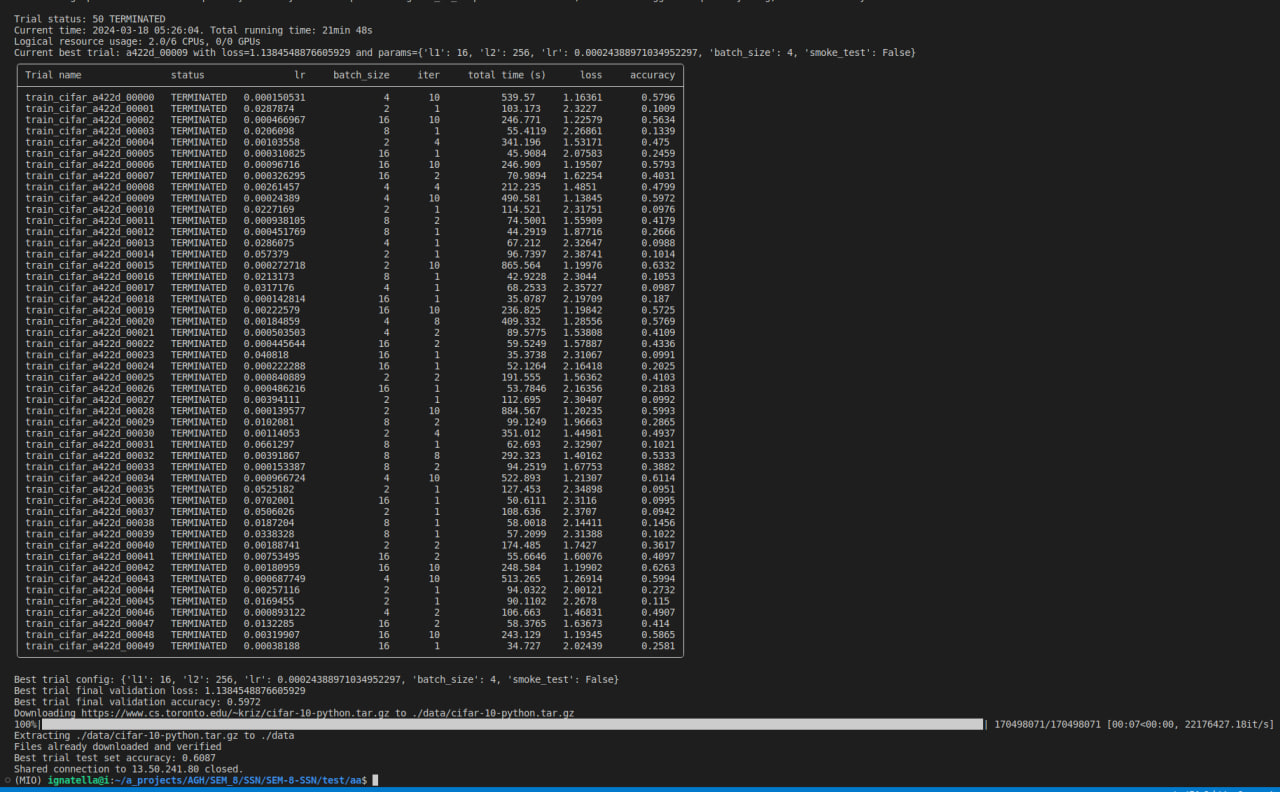

A tak wyglądał proces uczenia:

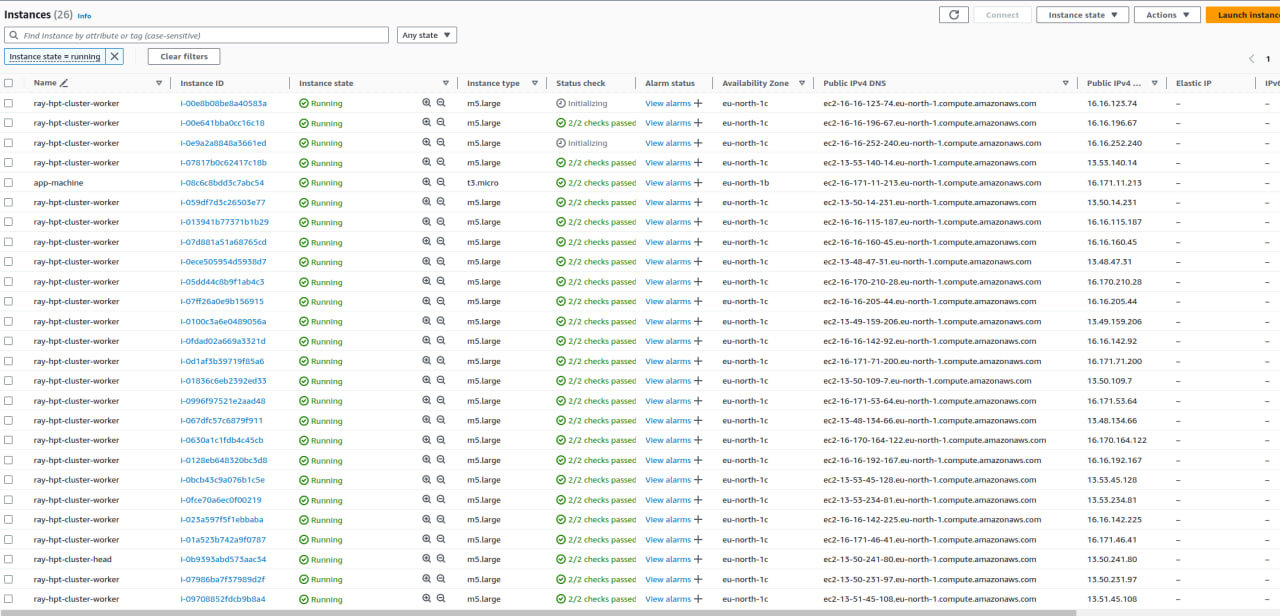

Więc w przypadku CIFAR10 zostałem bardzo zadowolony z wyników